In [ ]:
import torch
import torch.nn as nn
import utility_functions as uf
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.options.display.max_columns = None
importlib.reload(uf)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Data Loading

In [ ]:
""" # Loading the data from helper function
timeseries = uf.TimeseriesTorch('raw_data/', 43) """

In [ ]:
""" print(timeseries.train[0][0])
print(timeseries.train[0][1])
print(timeseries.train[1]) """

In [ ]:
# Loading the data manually
data1 = pd.read_table("raw_data/sepsisexp_timeseries_partition-A.tsv")
data2 = pd.read_table("raw_data/sepsisexp_timeseries_partition-B.tsv")
data3 = pd.read_table("raw_data/sepsisexp_timeseries_partition-C.tsv")
data4 = pd.read_table("raw_data/sepsisexp_timeseries_partition-D.tsv")

In [ ]:
# Setting partitions, original authors used these for cross validation. 
# The dataset is split into four partitions (A–D) that are used in the 4-fold cross validation experiments in (Schamoni et al., 2022). 
data1["partition"] = 1
data2["partition"] = 2
data3["partition"] = 3
data4["partition"] = 4

In [ ]:
data_orig = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [ ]:
df = data_orig.copy()

In [ ]:
df.isna().sum()

In [ ]:
df.shape

In [ ]:
df["timestep"]


In [ ]:

for partition, group_data in df.groupby('partition'):
    print(f"Partition: {partition}")
    print(group_data.head(), "\n")



In [ ]:
#Removes rows for each patient after severity>=2 as we want to predict before the patient get sepsis. 
#Also marks the last (input hour) rows as targets.

def setSepsisColumn(df_input, colName, hours):
    hours_multiplier = 2  # Assuming this is to convert hours to some unit, adjust as necessary
    hours = hours * hours_multiplier
    df_input[colName] = 0
    df_result = df_input.copy()

    for pid in df_input["id"].unique():
        # Filter rows where sepsis == 1 for the current pid
        filtered_df = df_input[(df_input["id"] == pid) & (df_input["sepsis"] == 1)]
        last_n_per_id = filtered_df.groupby('id').tail(hours)
        
        # Get the indices of the rows to update
        indices_to_update = last_n_per_id.index
        
        # Set colName to 1 for these indices
        df_result.loc[indices_to_update, colName] = 1

    return df_result




df_test = df.copy()
df_test = setSepsisColumn(df_test, "2hourSepsis", 2)
df_test = setSepsisColumn(df_test, "4hourSepsis", 4)
df_test = setSepsisColumn(df_test, "6hourSepsis", 6)

In [ ]:
df_test[df_test["sepsis"] == 1]

In [ ]:

unique_ids_count_one_2h = df_test[df_test["sepsis"] == 1]['id'].nunique()
unique_ids_count_zero_2h = df_test[df_test["sepsis"] == 0]['id'].nunique()

print("2h 1:", unique_ids_count_one_2h)
print("2h 0:", unique_ids_count_zero_2h)

print(df_test["2hourSepsis"].value_counts())
print(df_test["2hourSepsis"].value_counts())
print(df_test["4hourSepsis"].value_counts())
print(df_test["6hourSepsis"].value_counts())
print(df_test["sepsis"].value_counts())
print(df["sepsis"].value_counts())


In [ ]:
""" df_sort = df.sort_values(by=['id','timestep'])
df_sort_sepsis = df_sort[df_sort["sepsis"] == 1]

for pid in df_sort_sepsis['id'].unique():
    id_index = df_sort_sepsis[df_sort_sepsis["id"] == pid].index
    for i in range(len(id_index)):
        if i + 8 < len(id_index):
            if 1 in df.loc[id_index[i:i+8], 'severity'].values and 2 in df.loc[id_index[i+1:i+9], 'severity'].values:
                df_sort_sepsis.at[id_index[i], '4hourSepsis'] = 1
                # Drop rows where id_index > i for the same pid
                #df_sort_sepsis.drop(id_index[i+10:], inplace=True) """



In [ ]:
""" df_sort=df.copy()

df_sort['FirstOccurrenceFlag'] = 0

for pid in df_sort['id'].unique():
    # Extract indices for this patient where sepsis == 1
    patient_indices = df_sort[(df_sort['id'] == pid) & (df_sort['sepsis'] == 1)].index
    
    # Check the condition and flag the first occurrence
    for i in range(len(patient_indices)):
        if i + 8 < len(patient_indices):
            current_indices = patient_indices[i:i+8]
            next_indices = patient_indices[i+1:i+9]
            if 1 in df_sort.loc[current_indices, 'severity'].values and 2 in df_sort.loc[next_indices, 'severity'].values:
                df_sort.at[current_indices[0], 'FirstOccurrenceFlag'] = 1
                break  # Stop after flagging the first occurrence """

## Preprocess

In [ ]:
df_prep = df_test.copy()

In [ ]:
cols_to_drop = ["severity",'timestep',]
df_prep.drop(columns=cols_to_drop, inplace=True)

In [ ]:
df_2hr = df_prep.drop(["4hourSepsis", "6hourSepsis", ], axis=1)
df_4hr = df_prep.drop(["2hourSepsis", "6hourSepsis", ], axis=1)
df_6hr = df_prep.drop(["2hourSepsis", "4hourSepsis", ], axis=1)
df_6hr

In [ ]:
""" # Last column in df must be target
dataset = uf.TimeseriesTorchDF(df_6hr)
timeseries = dataset.load_series()
 """


In [ ]:
patient = df[(df["id"] == 12143) & (df["severity"] <= 2)]
patient

In [ ]:
patient = df_6hr[df_6hr["id"] == 12143]
patient

In [ ]:
patient.tail(20)

In [ ]:
""" import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cols_to_plt = [col for col in patient.columns if col not in ["id", "sepsis", "6hourSepsis", "age"]]
sns.set_style("whitegrid")
num_plots = len(cols_to_plt)
num_columns = 2  # Number of columns in the plot grid
num_rows = num_plots // num_columns + (1 if num_plots % num_columns else 0)  # Calculate required number of rows

fig, axes = plt.subplots(num_rows, num_columns, figsize=(7 * num_columns, 4 * num_rows))
fig.tight_layout(pad=4.0)  # Adjust spacing between plots

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(cols_to_plt):
    sns.lineplot(ax=axes[i], x=patient.index, y=col, data=patient, errorbar=None)
    axes[i].set_title(f"{col} Over Time")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel(col)

# If the number of plots is odd, the last subplot will be empty, so hide it
if num_plots % num_columns:
    axes[-1].set_visible(False)

plt.show()

 """


In [ ]:
""" print(f"Series: {timeseries[0].size()}")
print(f"Targets: {timeseries[1].size()}") """

In [ ]:
#checking if data is normalized
df_6hr.describe()
#it's somehow close to a standardized form with mean=0 and std=1 being perfectly normalized.

In [ ]:
df_2hr


In [ ]:
max_len = min(df_2hr[df_2hr["sepsis"] == 1].groupby('id').size())
max_len

group_size = df_2hr[df_2hr["sepsis"] == 1].groupby('id').size()
max_size = group_size.max()
ids_with_max_rows = group_size[group_size == max_size].index.tolist()
print(f"ID(s) with sepsis with the minimum number of rows: {ids_with_max_rows}, Length: {max_len}")

In [ ]:
df_2hr.shape

In [430]:
def convert_dataframe(df_input):
    df_dropped = df_input.drop(columns=["sepsis"])
    #df_dropped.drop_duplicates(inplace=True)
    features = df_dropped.columns[:-1] #all but last column as features
    target_column = df_dropped.columns[-1] #last column as target
    print(target_column)
    #target_column error here <---
    # Number of features, excluding the 'id' column and last column (target)
    num_features = len(features) - 1  # Excluding 'id' column 
    #num_features = df_dropped.drop(columns=["id"], axis=1).shape[1] #old with target included


    # Pre-allocate a 3D array for features and 2D array for target
    num_sequences = df_dropped['id'].nunique()
    print(num_sequences)
    data_3d = np.zeros((num_sequences, max_len, num_features))
    target_2d = np.zeros((num_sequences, max_len))
    print(data_3d.shape)
    print(target_2d.shape)

    print("features:",features)

    # Assuming you have defined 'max_len', 'data_3d', 'target_2d', and 'df_dropped' correctly
    for i, (pid, group) in enumerate(df_dropped.groupby('id')):
        # Drop 'id' column and select only the relevant features for this group
        features_data = group[features[1:]]  # Assuming 'features[1:]' skips 'id'
        print("features: ", features_data.columns)
        # Ensure we only take the last 'max_len' rows if this patient has more data than 'max_len'
        if len(group) > max_len:
            features_data = features_data.iloc[-max_len:]  # Select last 'max_len' rows
            target_data = group[target_column].iloc[-max_len:]
        else:
            target_data = group[target_column]
        
        # Calculate starting index if we have fewer than 'max_len' data points
        start_idx = max_len - len(features_data)
        
        # Fill the data into our pre-allocated arrays
        data_3d[i, start_idx:, :] = features_data.to_numpy()
        target_2d[i, start_idx:] = target_data.to_numpy()

    # Replace filled zeroes with the partition for that patient
    for i in range(data_3d.shape[0]):
        slice_2d_last_col = data_3d[i, :, -1] 
        non_zero_values = slice_2d_last_col[slice_2d_last_col != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            data_3d[i, slice_2d_last_col == 0, -1] = replacement_value
    
    np.unique(data_3d[:,:,-1])

    # Verify shapes and some contents
    print(f"data_3d shape: {data_3d.shape}, target_2d shape: {target_2d.shape}")
    return data_3d, target_2d

In [431]:
data_3d_2h, target_2d_2h = convert_dataframe(df_2hr)
data_3d_4h, target_2d_4h = convert_dataframe(df_4hr)
data_3d_6h, target_2d_6h = convert_dataframe(df_6hr)


2hourSepsis
1275
(1275, 121, 44)
(1275, 121)
features: Index(['id', 'respiratory_minute_volume', 'heart_rate', 'leukocytes',
       'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph',
       'bilirubin', 'blood_urea_nitrogen', 'creatinine', 'diastolic_bp',
       'fraction_of_inspired_o2', 'mean_bp', 'partial_pressure_art._o2',
       'systolic_bp', 'thrombocytes', 'horowitz_index', 'bun/creatinine_ratio',
       'delta-temperature', 'lactate', 'bicarbonate', 'c-reactive_protein',
       'hemoglobin', 'heart_time_volume', 'lymphocytes', 'sodium',
       'pancreatic_lipase', 'procalcitonin', 'quick_score',
       'oxygen_saturation', 'blood_glucose', 'base_excess', 'chloride',
       'calcium', 'potassium', 'mixed_venous_oxygen_saturation',
       'urine_output', 'net balance', 'alanine_transaminase',
       'aspartate_transaminase', 'stroke_volume', 'svri', 'age', 'partition'],
      dtype='object')
features:  Index(['respiratory_minute_volume', 'heart_rate', 'leukocytes',

## Test and validation set

In [ ]:
""" train_df = df_prep[df_prep['partition'].isin([1, 2])]
val_df = df_prep[df_prep['partition'] == 3]
test_df = df_prep[df_prep['partition'] == 4]

# Extracting features and labels for each set
X_train, y_train = train_df.drop(['partition'], axis=1), train_df['y']
X_val, y_val = val_df.drop(['partition'], axis=1), val_df['y']
X_test, y_test = test_df.drop(['partition'], axis=1), test_df['y'] """


In [ ]:
""" import numpy as np

#data_3d
#target_2d
from sklearn.model_selection import train_test_split
# Split into training/testing and validation sets (80% train/test, 20% validation)
#X_train_test, X_val, y_train_test, y_val = train_test_split(data_3d, target_2d, test_size=0.2, random_state=42)
# If needed, further split the training/testing set into separate training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

strat_fold = np.array([97])p.array([97])

#'partition'


array([97])


Y_copy=target_2d.copy()
X_copy=data_3d.copy()

# Split data into train, test, and validation
test_fold = 10
val_fold = 9
# Extract indices for validation, training, and test to ensure consistency
#val_indices = np.where(Y_copy.strat_fold == val_fold)[0]
#train_test_indices = np.where(Y_copy.strat_fold != val_fold)[0]
#test_indices = np.where(Y_copy.strat_fold == test_fold)[0]
#train_indices = np.where((Y_copy.strat_fold != val_fold) & (Y_copy.strat_fold != test_fold))[0]


# Extract indices for validation, training, and test to ensure consistency
val_indices = np.where(strat_fold == val_fold)[0]
test_indices = np.where(strat_fold == test_fold)[0]
train_indices = np.where((strat_fold != val_fold) & (strat_fold != test_fold))[0]



# Validation set
X_val = X_copy[val_indices]
y_val = Y_copy[val_indices]
# Train set
X_train = X_copy[train_indices]
y_train = Y_copy[train_indices]
# Test set
X_test = X_copy[test_indices]
y_test = Y_copy[test_indices]
1 """

In [ ]:
""" from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


#X_train =X_train.clone().detach()
#y_train= y_train.clone().detach()
#X_test = X_test.clone().detach()
#y_test = y_test.clone().detach()
#X_val = X_val.clone().detach()
#y_val = y_val.clone().detach()

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32) #hääär
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size) """

In [ ]:
features_e = data_3d.copy()
targets_e = target_2d.copy()

In [ ]:
partitions = features_e[:, 0, -1]
print(partitions)
partitions = np.array(partitions)
np.unique(partitions)
print(np.unique(partitions))

In [ ]:
# Define which partition value you want to use for testing
test_partition_val = 1
train_partition_val=2
train_partition_val2 =4 #should it be 0?
val_partition_val=3


# Split data
X_train = features_e[(partitions == train_partition_val) | (partitions == train_partition_val2), :, :-1]  # Exclude partition feature for training data
y_train = targets_e[(partitions == train_partition_val) | (partitions == train_partition_val2), :]
X_test = features_e[partitions == test_partition_val, :, :-1]  # Exclude partition feature for test data
y_test = targets_e[partitions == test_partition_val, :]
X_val = features_e[partitions == val_partition_val, :, :-1]  # Exclude partition feature for test data
y_val = targets_e[partitions == val_partition_val, :]

X_train.shape


In [ ]:
class BinaryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=5, dropout_rate=0):
        super(BinaryLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0.0)
        
        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Apply dropout
        out = self.dropout(out)

        # Decode the hidden state of each time step
        out = self.fc(out)  # Now out is of shape (batch_size, seq_length, output_dim)
        return out



In [ ]:
""" from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_temp, y_train, y_temp = train_test_split(features_e, targets_e, test_size=0.3, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size) """

In [ ]:
""" import torch

# If y_train is not already a flat tensor, flatten it first
y_train_flat = y_train.flatten()

# Count occurrences of 1's (positive class)
count_ones = torch.sum(y_train_flat).item()

# Count occurrences of 0's (negative class) by subtracting count of 1's from total number of elements
count_zeros = y_train_flat.numel() - count_ones

print(f"Count of 0's (Class 0): {count_zeros}")
print(f"Count of 1's (Class 1): {count_ones}") """


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch
def get_class_weights(y_train):
    # Convert y_train from one-hot encoding to integer class labels if necessary
    # Assuming y_train is a PyTorch tensor for simplicity; adapt as needed
    if len(y_train.shape) > 1:  # More than one dimension implies one-hot encoding
        y_train_int = torch.argmax(y_train, dim=1).cpu().numpy()
        #print("length higher than 1")
    else:
        y_train_int = y_train.cpu().numpy()  # Assuming y_train is already class labels

    # Compute class weight
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
    class_weights = torch.tensor(weights, dtype=torch.float)
    class_weights = class_weights.to(device)
    return class_weights

In [ ]:
#is used to validate a model during training
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# used after with test data
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Squeeze the outputs to remove the extra dimension
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            probabilities = torch.sigmoid(outputs)
            
            predicted = probabilities > 0.5
            predictions.append(predicted.cpu().numpy())
            actuals.append(labels.cpu().numpy())


    avg_loss = total_loss / len(data_loader)
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    return avg_loss, predictions, actuals

In [ ]:
def train_and_validate(model, criterion, optimizer, train_loader, val_loader):
    validation_losses = []
    training_losses = []
    patience = 10
    epochs = 50
    best_epoch=0
    min_epochs = 10
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
        val_loss = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}, Training Loss: {loss.item()} | Validation Loss: {val_loss}")
        
        training_losses.append(loss.item())
        validation_losses.append(val_loss)
        # Early stopping and model saving to prevent overfitting

        if (epoch > min_epochs):
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # Save the current model state
                best_epoch = epoch
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print("Early stopping triggered!")
                print(f"Best epoch: {best_epoch + 1}")
                break
    
    model.load_state_dict(best_model_state)
    return model #, validation_losses, training_losses, best_epoch


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16
# Example: 4-fold cross-validation based on unique partition values
unique_partitions = np.unique(partitions)
#unique_partitions = unique_partitions[unique_partitions != val_partition_val]  # Exclude validation partition
kf = KFold(n_splits=len(unique_partitions), shuffle=True, random_state=42)
kf

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, auc, roc_curve, roc_auc_score, confusion_matrix
def get_eval(model, test_loader, criterion):
    test_loss, test_predictions, test_actuals = evaluate(model=model, data_loader=test_loader, criterion=criterion, device=device)
    # Squeeze the innermost dimension and convert booleans to integers
    test_predictions_squeezed = np.squeeze(test_predictions).astype(int)

    # Flatten both arrays
    test_actuals_flat = test_actuals.ravel()
    test_predictions_flat = test_predictions_squeezed.ravel()

    # Proceed with metric calculations
    accuracy = accuracy_score(test_actuals_flat, test_predictions_flat)
    prec = precision_score(test_actuals_flat, test_predictions_flat, average='binary')
    recall = recall_score(test_actuals_flat, test_predictions_flat, average='binary')
    f1 = f1_score(test_actuals_flat, test_predictions_flat, average='binary')
    hamming = hamming_loss(test_actuals_flat, test_predictions_flat)
    cm = confusion_matrix(test_actuals_flat, test_predictions_flat)
    fpr, tpr, _ = roc_curve(test_actuals_flat, test_predictions_flat)
    auc_roc = auc(fpr, tpr)
    return {"accuracy" : accuracy, "precision" : prec, "recall" : recall, "f1" : f1, "hamming" : hamming, "cm" : cm, "auc_roc" : auc_roc}

In [ ]:
def initModel(y_tensors, num_layers, hidden_dim):
    class_weights = get_class_weights(y_tensors);
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BinaryLSTM(input_dim=43, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [ ]:


results = []
metrics_summary = {} # Used to store validation-loss, training loss, batch-sizes etc.
loop_no = 0
loop_max = 4*2

for train_index, test_index in kf.split(unique_partitions):
    for layer in (2, 3):
        #for hidden_dim in (200):
        hidden_dim = 200
        loop_no += 1
        print("Loop:", loop_no ,"/", loop_max) #prints nr of loops left
        print(f"Hyper params - Layers: {layer}, Hidden_dim: {hidden_dim}")
        train_partitions = unique_partitions[train_index]
        test_partition = unique_partitions[test_index][0]  # Assuming each test_index array only has one element
        print(f"Train partitions: {train_partitions}")
        print(f"Test partition: {test_partition}")

        X_train_fold = data_3d[np.isin(partitions, train_partitions), :, :-1]
        y_train_fold = target_2d[np.isin(partitions, train_partitions), :]
        X_test_fold = data_3d[partitions == test_partition, :, :-1]
        y_test_fold = target_2d[partitions == test_partition, :]
        
        # Static validation set across folds
        #X_val = features_e[partitions == val_partition_val, :, :-1]  # Exclude partition feature
        #y_val = targets_e[partitions == val_partition_val, :]

        #convert to tensor
        X_train = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train = torch.tensor(y_train_fold, dtype=torch.float32)
        X_test = torch.tensor(X_test_fold, dtype=torch.float32)
        y_test = torch.tensor(y_test_fold, dtype=torch.float32)
        #X_val=torch.tensor(X_val, dtype=torch.float32)
        #y_val = torch.tensor(y_val, dtype=torch.float32)

        train_data = TensorDataset(X_train, y_train)
        test_data = TensorDataset(X_test, y_test)
        #val_data = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
        test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
        #val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
        model, criterion, optimizer = initModel(y_train, layer, hidden_dim)

        model = train_and_validate(model, criterion, optimizer, train_loader, test_loader)
        #accuracy, prec, recall, f1, hamming, cm,fpr,tpr,auc_roc = get_eval(model, test_loader, criterion)
        #test_loss, test_predictions, test_actuals = evaluate(model=model, data_loader=test_loader, criterion=criterion, device=device)
        
        #lägg till resultat i results
        metrics_summary.update({"model":model, "layers":layer, "hidden":hidden_dim, "metrics" : get_eval(model, test_loader, criterion)})
        results.append(metrics_summary.copy())

    
    
    # Now use X_train_fold, y_train_fold, X_test_fold, y_test_fold for training and evaluation in this fold


In [ ]:
results

In [ ]:
for summary in results:
    # Assuming `summary` is a dictionary with keys "model", "layers", "hidden", and "metrics"
    # And assuming `metrics` is another dictionary with the evaluation metrics
    metrics = summary["metrics"]  # This is the dictionary that contains our metrics
    
    print(f"Layers: {summary['layers']}, Hidden dim: {summary['hidden']}")
    print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}, AUC-ROC: {metrics['auc_roc']:.4f}")
    print("\n          Predicted")
    print("          0      1")
    cm = metrics['cm']  # Assuming this is a confusion matrix
    print(f"Actual 0  {cm[0,0]}  {cm[0,1]}")
    print(f"       1  {cm[1,0]}    {cm[1,1]}\n")



In [428]:
import matplotlib.pyplot as plt

# Extracting metrics for plotting
layers_list = [summary['layers'] for summary in results]
hidden_dim_list = [summary['hidden'] for summary in results]
accuracy_list = [summary['metrics']['accuracy'] for summary in results]
precision_list = [summary['metrics']['precision'] for summary in results]
recall_list = [summary['metrics']['recall'] for summary in results]
f1_list = [summary['metrics']['f1'] for summary in results]
auc_roc_list = [summary['metrics']['auc_roc'] for summary in results]

# Assume you want to compare models based on F1 score to select the best model
best_f1_index = f1_list.index(max(f1_list))
best_model_summary = results[best_f1_index]
print(f"Best Model based on F1 Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, F1 Score = {best_model_summary['metrics']['f1']:.4f}")


#best AUC ROC score:
best_auc_roc_index = auc_roc_list.index(max(auc_roc_list))
best_model_summary = results[best_auc_roc_index]
print(f"Best Model based on AUC ROC Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, AUC-ROC-Score = {best_model_summary['metrics']['auc_roc']:.4f}")


#best recall score:
recall_index = recall_list.index(max(recall_list))
best_model_summary = results[recall_index]
print(f"Best Model based on recall Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, Recall-Score = {best_model_summary['metrics']['recall']:.4f}")


#best recall score:
precision_index = precision_list.index(max(precision_list))
best_model_summary = results[precision_index]
print(f"Best Model based on precision Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, Precision-Score = {best_model_summary['metrics']['precision']:.4f}")


Best Model based on F1 Score: Layers = 2, Hidden Dim = 200, F1 Score = 0.5138
Best Model based on AUC ROC Score: Layers = 2, Hidden Dim = 200, AUC-ROC-Score = 0.8040
Best Model based on recall Score: Layers = 2, Hidden Dim = 200, Recall-Score = 0.6273
Best Model based on precision Score: Layers = 3, Hidden Dim = 200, Precision-Score = 0.6029


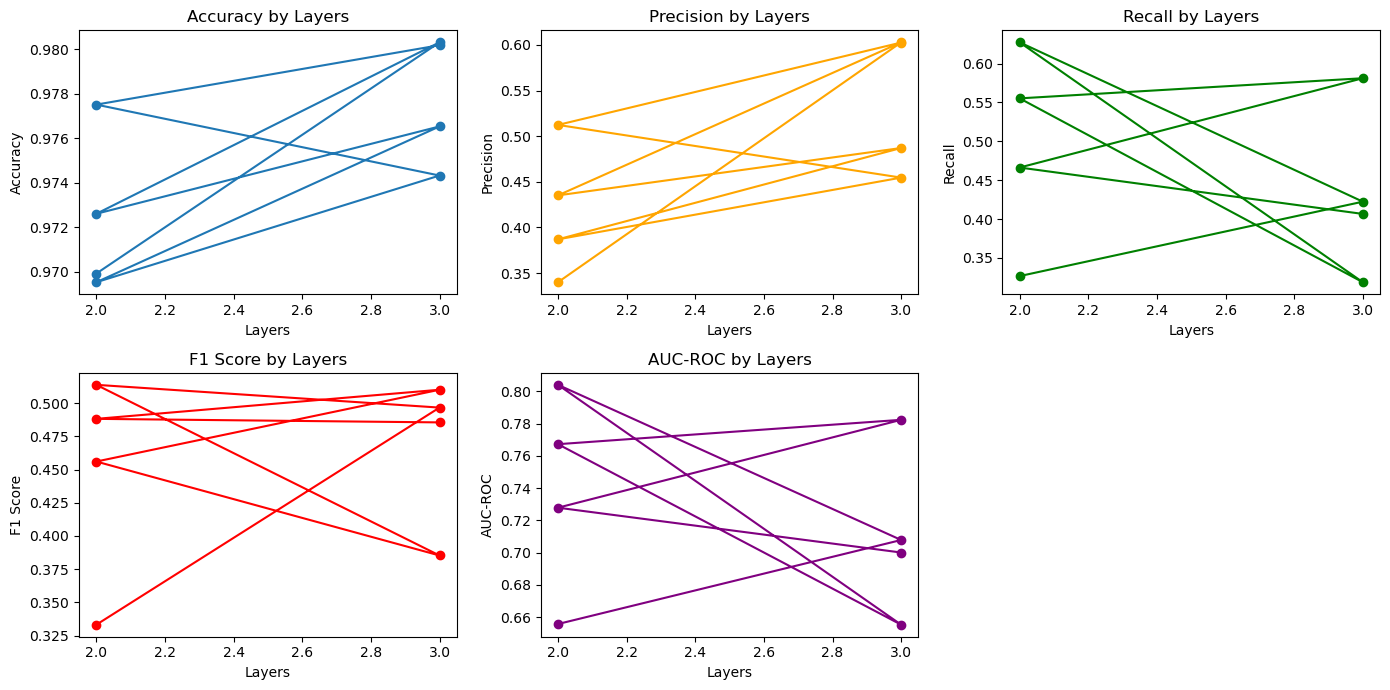

In [427]:
# Setting up the figure
plt.figure(figsize=(14, 7))

# Plotting accuracy
plt.subplot(2, 3, 1)
plt.plot(layers_list, accuracy_list, marker='o', label='Accuracy')
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy by Layers')

# Plotting precision
plt.subplot(2, 3, 2)
plt.plot(layers_list, precision_list, marker='o', color='orange', label='Precision')
plt.xlabel('Layers')
plt.ylabel('Precision')
plt.title('Precision by Layers')

# Plotting recall
plt.subplot(2, 3, 3)
plt.plot(layers_list, recall_list, marker='o', color='green', label='Recall')
plt.xlabel('Layers')
plt.ylabel('Recall')
plt.title('Recall by Layers')

# Plotting F1
plt.subplot(2, 3, 4)
plt.plot(layers_list, f1_list, marker='o', color='red', label='F1 Score')
plt.xlabel('Layers')
plt.ylabel('F1 Score')
plt.title('F1 Score by Layers')

# Plotting AUC-ROC
plt.subplot(2, 3, 5)
plt.plot(layers_list, auc_roc_list, marker='o', color='purple', label='AUC-ROC')
plt.xlabel('Layers')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC by Layers')

plt.tight_layout()
plt.show()


In [ ]:
X_val_np = X_val.numpy() if isinstance(X_val, torch.Tensor) else X_val
y_val_np = y_val.numpy() if isinstance(y_val, torch.Tensor) else y_val


print(X_val_np.shape)
print(y_val_np.shape)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def permutation_importance_sequential(model, X, y, metric=accuracy_score, device='cpu'):
    model.eval()
    
    # Flatten the predictions if your model outputs one prediction per sequence
    with torch.no_grad():
        original_preds = model(torch.tensor(X, dtype=torch.float).to(device)).sigmoid().cpu().numpy()
    original_preds = (original_preds > 0.5).astype(int).flatten()

    y_flat = y.flatten().astype(int)
    original_score = metric(y_flat, original_preds)

    importance_scores = {}
    for feature in range(X.shape[2]):  # Iterate over each feature
        X_shuffled = X.copy()
        for i in range(X.shape[0]):  # Shuffle feature across all time steps for each sample
            np.random.shuffle(X_shuffled[i, :, feature])

        with torch.no_grad():
            shuffled_preds = model(torch.tensor(X_shuffled, dtype=torch.float).to(device)).sigmoid().cpu().numpy()
        shuffled_preds = (shuffled_preds > 0.5).astype(int).flatten()

        shuffled_score = metric(y_flat, shuffled_preds)
        importance_scores[feature] = original_score - shuffled_score

    return importance_scores


# Assuming X_val and y_val are your validation features and labels in NumPy array format
X_val_np = X_val.numpy() if isinstance(X_val, torch.Tensor) else X_val
y_val_np = y_val.numpy() if isinstance(y_val, torch.Tensor) else y_val

importance_scores = permutation_importance_sequential(model, X_val_np, y_val_np, device=device)

In [ ]:
newDict = {}
features_map = [feature for feature in features if feature != "id"]
for index, importance in importance_scores.items():
    feature_name = features_map[index] 
    newDict[feature_name] = importance

importances_df = pd.DataFrame(list(newDict.items()), columns=['Feature', 'Importance'])

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df.sort_values('Importance', ascending=False), x='Importance', y='Feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Training

## Evaluate and visualize results

In [ ]:

#train_data = TensorDataset(X_train, y_train)
#test_data = TensorDataset(X_test, y_test)
#val_data = TensorDataset(X_val, y_val)

#batch_size = 32
#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#test_loader = DataLoader(test_data, batch_size=batch_size)
#val_loader = DataLoader(val_data, batch_size=batch_size)

import torch
from torch.utils.data import DataLoader, TensorDataset


X_test_tensor = X_test.clone().detach()
y_test_tensor = y_test.clone().detach()


#X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Ensure these tensors are on the correct device (CPU or GPU)
#X_test_tensor = X_test_tensor.to(device)
#y_test_tensor = y_test_tensor.to(device)





model.eval()  # Set the model to evaluation mode

# Define a function to calculate accuracy
def calculate_accuracy(outputs, targets):
    predicted = torch.sigmoid(outputs) > 0.5
    correct = (predicted == targets).float().sum()
    return correct / targets.numel()

# Assuming X_test_tensor and y_test_tensor are correctly shaped and on the appropriate device
baseline_outputs = torch.cat([model(xb.to(device)) for xb, _ in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)])
baseline_acc = calculate_accuracy(baseline_outputs, y_test_tensor.to(device))

# Calculate feature importance
importances = []
num_features = X_test_tensor.shape[2]  # Assuming features are in the last dimension

for i in range(num_features):
    # Clone and shuffle the feature values across all examples in the batch
    X_test_shuffled = X_test_tensor.clone()
    shuffling_idx = torch.randperm(X_test_shuffled.size(0))
    X_test_shuffled[:, :, i] = X_test_shuffled[shuffling_idx, :, i]
    
    # Calculate accuracy with the shuffled data
    shuffled_outputs = torch.cat([model(xb.to(device)) for xb, _ in DataLoader(TensorDataset(X_test_shuffled, y_test_tensor), batch_size=32)])
    shuffled_acc = calculate_accuracy(shuffled_outputs, y_test_tensor.to(device))
    
    # Importance is the difference in accuracy
    importance_score = baseline_acc - shuffled_acc
    importances.append(importance_score.item())

# Plotting feature importances
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.bar(np.arange(num_features), importances)
plt.xlabel('Features')
plt.ylabel('Decrease in Accuracy')
plt.title('Feature Importance')
plt.xticks(np.arange(num_features), features, rotation='vertical')
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_test and y_test are your features and labels tensors
#X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_test_tensor = X_test.clone().detach()
y_test_tensor = y_test.clone().detach()

def calculate_importance(X_test, y_test, model):
    baseline_acc = calculate_accuracy(model, X_test, y_test)
    importances = []
    for i in range(X_test.shape[2]):  # Iterate over each feature
        X_test_shuffled = X_test.clone()
        X_test_shuffled[:, :, i] = X_test_shuffled[:, torch.randperm(X_test.size(0)), i]
        #shuffled_acc = calculate_accuracy(model, X_test_shuffled, y_test)

        # Calculate accuracy with the shuffled data
        shuffled_outputs = torch.cat([model(xb.to(device)) for xb, _ in DataLoader(TensorDataset(X_test_shuffled, y_test_tensor), batch_size=32)])
        shuffled_acc = calculate_accuracy(shuffled_outputs, y_test_tensor.to(device))

        importance = baseline_acc - shuffled_acc  # Decrease in accuracy indicates importance
        importances.append(importance)
    return importances

# Calculate feature importance
importances = calculate_importance(X_test_tensor, y_test_tensor, best_model_state)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assume X_test_tensor and y_test_tensor are your input features and labels tensors, respectively
#X_test_tensor = X_test.clone().detach()
#y_test_tensor = y_test.clone().detach()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Move tensors to the same device as the model
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

def calculate_accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.sigmoid(outputs) > 0.5
        correct = (predicted == y_test).float().sum()
    return correct.item() / y_test.numel()

def calculate_importance(model, X_test, y_test):
    baseline_acc = calculate_accuracy(model, X_test, y_test)
    importances = []
    for i in range(X_test.shape[2]):  # Loop over each feature
        X_test_shuffled = X_test.clone()
        shuffle_indices = torch.randperm(X_test.size(0))
        X_test_shuffled[:, :, i] = X_test[:, shuffle_indices, i]
        shuffled_acc = calculate_accuracy(model, X_test_shuffled, y_test)
        importance = baseline_acc - shuffled_acc
        importances.append(importance)
    return importances

# Example usage
# Ensure your model is loaded correctly and replace `model` with your actual model variable
importances = calculate_importance(model, X_test_tensor, y_test_tensor)
print(importances)


## Result and discussion